# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 3 — Exponential Families


---

Submission by:
* Batuhan, Oezcoemlekci, Matrikelnummer: 6300476
* Aakarsh, Nair, Matrikelnummer: 6546577

# Exercise 3.1 (Theory Exercise)

### (a) 

In the lecture we encountered the *Gamma* distribution, the exponential family with pdf: 

$$
p(x | a, b) = \mathcal{G}(x; a, b) = \frac{b^a}{\Gamma(a)} x^{a-1} e^{-bx}
$$

with 
$$
\Gamma(z) := \int_{0}^{\infty} t^{z-1}e^{-t} dt
$$

We already saw that the Gamma function is a generalization of the factorial function: $\Gamma(n) = (n-1)!$ for $n \in \mathbb{N}$. Like the Beta integral, it is arguably an intractable object, although extremely good numerical approximations exist. So as in the Beta case, we can construct a more tractable approximation by constructing the *Laplace Approximation*. To do so, consider the unnormalized density $\tilde{p}(x | a, b) = x^{a-1}e^{-bx}$, and compute the first two derivatives of its logarithm. Use them to find the mode, and the curvature at the mode, and construct a Taylor approximation. Interpret it as the logarithm of a Gaussian Distribution, and find its parameters, as in the lecture. Write out an explicit expression for mean and covariance of this Gaussian approximation in terms of a,b for full marks. 

Then consider the special case b=1. Show how it can be used to construct an analytic approximation for the Gamma function, known as *Stirling's approximation* (though it can be traced back to Abraham de Moivre's *Doctrine of Chances*, 1733)

### Answer:
We have been given that
$$
p(x|a,b) = \mathcal{G}(x;a,b) = \frac{b^a}{\Gamma(a)} x^{a-1} e^{-bx}
$$

with 
$$
\Gamma(z):= \int_0^{\infty} t^{z-1}e^{-t} dt
$$


Consider the unnormalized density:
$$
\tilde{p}(x) = x^{a-1}e^{-bx}
$$

Then the  log of the unnormalized density becomes:

$$
log(\tilde{p}(x)) = (a-1)\log(x) - bx
$$

Then taking the first two derivatives we get: 

$$
\frac{\partial \log(\tilde{p})}{\partial x} = \frac{a-1}{x} -b = 0
$$
$$ a-1 = bx$$
Which implies the critical point $x^{*}$ is 
$$
x^{*} = \frac{(a-1)}{b} = \hat{x}_{mode}
$$


Now we compute the second derivative at the mode to get the curvature at the mode.

$$
\left. \frac{\partial^2 \tilde{p}}{\partial x^2} \right|_{x=x^{*}} = \left. \frac{1-a}{x^2} \right|_{x=x^{*}} = \frac{(1-a)b^2}{(a-1)^2} = -\frac{b^2}{a-1}
$$

and thus :
$$
\sigma^2 = \frac{(a-1)}{b^2}
$$



Finally using the above variance we get the approximation $q(x|a,b)$
$$
q(x | a,b) = \mathcal{N}\left(x; \mu=\frac{(a-1)}{b}, \sigma^2 = \frac{(a-1)}{b^2}\right) = \frac{b}{\sqrt{2\pi(a-1)}} e^{\frac{-b^2\left(x-\frac{(a-1)}{b}\right)^2}{2(a-1)}}
$$

Which simplifies for the special case $b=1$ to 
$$
q(x | a,b=1) = \mathcal{N}\left(x; \mu=(a-1), \sigma^2 = (a-1)\right) = \frac{1}{\sqrt{2\pi(a-1)}} e^{\frac{-\left(x-(a-1)\right)^2}{2(a-1)}}
$$

To find the *Stirling's approximation*:

We know that $\Gamma(a) = \int_{0}^{\infty} x^{(a-1)}e^{-x}dx = (a-1)!$, we also know that (Lecture 3 slide 35): 

$$
\int p(x|a,b) \approx   p(\hat{x})  \int \exp \left[ \frac{(x-\hat{x})^2}{2\sigma^2}\right] dx \approx 1
$$

When using $b=1$ for $\sigma^2 = (a-1)$  and $\hat{x}=(a-1)$, we get by first substituting the variance: 
$$
\frac{\hat{x}^{(a-1)}e^{-\hat{x}}}{\Gamma(a)} \int \exp \left[ -\frac{(x - \hat{x})^2}{2(a-1)} \right] dx \approx 1
$$
Then the mode

$$
\frac{(a-1)^{(a-1)}e^{-(a-1)}}{\Gamma(a)} \int \exp \left[ -\frac{(x - (a-1))^2}{2(a-1)} \right] dx \approx 1
$$

Which simplifies to : 

$$
\frac{(a-1)^{(a-1)}e^{-(a-1)}}{\Gamma(a)} \sqrt{2 \pi (a-1)} \approx 1
$$

Taking Gamma to other side we get 

$$
\Gamma(a) \approx (a-1)^{(a-1)} e^{-(a-1)} \sqrt{2\pi(a-1)}
$$

Using $n+1 = a$ we see the stirling approximation: 

$$
\Gamma(n+1) \approx n^n e^{-n} \sqrt{2\pi n} \approx \sqrt{2\pi n} \left(\frac{n}{e}\right)^n 
$$



### (b) 

We now move to the multivariate form of the Gamma distribution. Assume we are given $n$ observations $x_i \in \mathbb{R}^d$ drawn i.i.d from the multivariate Gaussian likelihood.

$$
P(x_i| \mu, \Sigma) = \mathcal{N}(x_i, \mu, \Sigma) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp \left( -\frac{1}{2} (x_i - \mu)^T \Sigma^{-1}(x_i - \mu) \right)
$$
Assume that we know the mean $\mu \in \mathbb{R}^d$ but not the symmetric positive definite precision matrix $\Sigma^{-1}$. Show that the conjugate prior for $\Sigma^{-1}$ under this likelihood is given by the *Wishart distribution*

$$
p(\Sigma^{-1}| W, \nu) = \mathcal{W}(\Sigma^{-1}| W, \nu) = \frac{|\Sigma^{-1}|^{(\nu-d-1)/2}}{2^{d\nu/2} |W|^{\nu/2} \Gamma_d(\nu/2)}\exp\left(-\frac{1}{2} \text{tr}(W\Sigma^{-1}) \right)
$$

Where tr is the trace. You do not need to prove the form of the normalization constant. It is known as the *multivariate Gamma function* and is given by:

$$
\Gamma_d(z) = \pi^{d(d-1)/4} \prod_{i=1}^{d} \Gamma \left(z + \frac{1-i}{2}\right)
$$

What is the posterior distribution of $\Sigma^{-1}$?

### Answer

We need to prove that the posterior distribution of $\Sigma^{-1}$ after observing the data $\{x_i\}$ is also in the same distibutional family as the prior. In other words: 


$$
p(\Sigma^{-1}| W, \nu, X) \propto p(X| \mu, \Sigma^{-1} ) p(\Sigma^{-1}| W, \nu)
$$

Where $p(\Sigma^{-1}| W, \nu, X)$ is the *Wishart distribution*. Using the i.i.d assuption for drawn samples we have: 

$$
p(\Sigma^{-1}| W, \nu, X) \propto \prod_{i} p(x_i|\mu, \Sigma^{-1}) p(\Sigma^{-1}| W, \nu) 
$$

Moreover the product is also a Guassian. 

Using the property of positive definite square matrix $\Sigma^{-1}$ we have: 

$$
(x_i - \mu)^{T} \Sigma^{-1} (x_i  - \mu) = \text{tr}((x_i - \mu)(x_i - \mu)^T\Sigma^{-1})
$$

For the multiplication of i.i.d Gaussians, it takes the form: 

$$
\prod_{i=1}^{n} A_i \exp \left[-\frac{1}{2}\text{tr}\left((x_i  - \mu )(x_i - \mu)^T\Sigma^{-1} \right)\right] = B \exp \left[  - \frac{1}{2} \text{tr}\left(\sum_{i=1}^{n} (x_i - \mu)(x_i - \mu)^T \Sigma^{-1} \right) \right]
$$


Finally multiplying the combined exponentials with the Wishart prior, we have: 


$$
p(\Sigma^{-1}| W',\nu', X ) \propto \left(\prod_{i=1}^n p(x_i | \mu, \Sigma^{-1}) \right) p(\Sigma^{-1}| W, \nu)
$$

Where $n$ is the number of observed points. Substituting the product of gaussians into this we get 

$$
p(\Sigma^{-1}| W',\nu', X ) \propto \left(\prod_{i=1}^n p(x_i | \mu, \Sigma^{-1}) \right) p(\Sigma^{-1}| W, \nu)
$$

Using the definition of the wisehart distribution  we know that: 

$$
p(\Sigma^{-1}| W, \nu) = \mathcal{W}(\Sigma^{-1}| W, \nu) = \frac{|\Sigma^{-1}|^{(\nu-d-1)/2}}{2^{d\nu/2} |W|^{\nu/2} \Gamma_d(\nu/2)}\exp\left(-\frac{1}{2} \text{tr}(W\Sigma^{-1}) \right)
$$

Substituting with the product of Gaussians and the Wishart prior we get: 

$$
p(\Sigma^{-1}| W',\nu', X ) \propto  \frac{\Sigma^{-n}}{(2\pi)^{nd/2}} \exp \left[  - \frac{1}{2} \text{tr}\left(\sum_{i=1}^{n} (x_i - \mu)(x_i - \mu)^T \Sigma^{-1} \right) \right] \frac{|\Sigma^{-1}|^{(\nu-d-1)/2}}{2^{d\nu/2} |W|^{\nu/2} \Gamma_d(\nu/2)}\exp\left[-\frac{1}{2} \text{tr}(W\Sigma^{-1}) \right]
$$

Which simplifies to : 

$$
p(\Sigma^{-1}| W',\nu', X ) \propto  \frac{|\Sigma^{-1}|^{(\nu+n-d-1)/2}}{2^{d(\nu+n)/2} C} \exp\left[-\frac{1}{2} \text{tr}(W^{-1} + \sum_{i=1}^n(x_i - \mu) (x_i - \mu )^T \Sigma^{-1}) \right]
$$

Where $C$ is a normalization constant. From this we clearly see that the posterior takes the form: 

$$
p(\Sigma^{-1}| W',\nu', X ) \propto p(\Sigma^{-1} | (W^{-1} + \sum_{i=1}^{n} (x_i  - \mu)(x_i - \mu)^T)^{-1}, \nu+n)
$$
Which is a Wisehard distributional form: 

$$
p(\Sigma^{-1}| W',\nu', X ) \propto  \text{Wishart}(\Sigma^{-1} | (W^{-1} + \sum_{i=1}^{n} (x_i  - \mu)(x_i - \mu)^T)^{-1}, \nu+n )
$$


# Exercise 3.2 (Coding Exercise)

Consider the abstract base class `ExponentialFamily` introduced in the lecture (reproduced below for easy reference). 

In [110]:
import jax
import numpy as np
import logging

from jax import numpy as jnp
from matplotlib import pyplot as plt
from numpy.typing import ArrayLike

from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})


logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

In [111]:
import abc
import functools

class ExponentialFamily(abc.ABC):
    @abc.abstractmethod
    def sufficient_statistics(self, x: ArrayLike | jnp.ndarray, /) -> jnp.ndarray:
        """Signature `(D)->(P)`"""

    @abc.abstractmethod
    def log_base_measure(self, x: ArrayLike | jnp.ndarray, /) -> jnp.ndarray:
        """Signature `(D)->()`"""

    @abc.abstractmethod
    def log_partition(self, parameters: ArrayLike | jnp.ndarray, /) -> jnp.ndarray:
        """Signature `(P)->()`"""

    def parameters_to_natural_parameters(
        self, parameters: ArrayLike | jnp.ndarray, /
    ) -> jnp.ndarray:
        """Signature `(P)->(P)`
        In some EF's, the canonical parameters are
        actually a transformation of the natural parameters.
        In such cases, this method should be overwritten to
        provide the inverse transformation.
        """
        return jnp.asarray(parameters)

    def logpdf(
        self, x: ArrayLike | jnp.ndarray, parameters: ArrayLike | jnp.ndarray, /
    ) -> jnp.ndarray:
        """Signature `(D),(P)->()`
        log p(x|parameters)
            = log h(x) + sufficient_statistics(x) @ natural_parameters - log Z(natural_parameters)
            = log base measure + linear term - log partition
        """
        x = jnp.asarray(x).astype(jnp.float32)
        log_base_measure = self.log_base_measure(x)
        natural_parameters = self.parameters_to_natural_parameters(parameters)
        st = self.sufficient_statistics(x)[..., None, :] 
        linear_term = (st  @ natural_parameters[..., None])[..., 0, 0]
        log_partition = self.log_partition(parameters)
        return log_base_measure + linear_term - log_partition

    def conjugate_log_partition(
        self, alpha: ArrayLike | jnp.ndarray, nu: ArrayLike | jnp.ndarray, /
    ) -> jnp.ndarray:
        """The log partition function of the conjugate exponential family.
        Signature `(P),()->()`
        If(!) this is available, it allows analytic construction of the conjugate prior (and thus analytic posterior inference).
        """
        raise NotImplementedError()

    def conjugate_prior(self) -> "ConjugateFamily":
        return ConjugateFamily(self)

    def predictive_log_marginal_pdf(
        self,
        x: ArrayLike | jnp.ndarray,
        conjugate_natural_parameters: ArrayLike | jnp.ndarray,
    ) -> jnp.ndarray:
        """ Signature `(D),(P)->()`
            log p(x|conjugate_natural_parameters)
            Your answer to Part B below should be implemented here.
        """
        # Implement $p(x) = h(x)\frac{F(\phi(x)+\alpha, \nu+1)}{F(\alpha, \nu)}$
        lbm = self.log_base_measure(x)
        st = self.sufficient_statistics(x) 
        alpha = conjugate_natural_parameters[:-1]
        nu =   conjugate_natural_parameters[-1]
        plm =  (lbm \
            + self.conjugate_log_partition(st + alpha, nu + 1))[...,0] \
            - self.conjugate_log_partition(alpha, nu)
        return plm
        
    
    def Laplace_predictive_log_marginal_pdf(
        self,
        x: ArrayLike | jnp.ndarray,
        conjugate_natural_parameters: ArrayLike | jnp.ndarray,
        mode: ArrayLike | jnp.ndarray,
    ) -> jnp.ndarray:
        """ Signature `(D),(P)->()`
            log p(x|conjugate_natural_parameters)
            Your answer to Part B below should be implemented here.
        """
        def log_pdf_fun(y):
            return -self.logpdf(y, conjugate_natural_parameters)
        hessian = jax.hessian(log_pdf_fun)(mode)
        hessian_inv = np.linalg.inv(hessian)
        return jax.scipy.stats.multivariate_normal.logpdf(jnp.asarray(x), mode, hessian_inv)

    def posterior_parameters(
        self,
        prior_natural_parameters: ArrayLike | jnp.ndarray,
        data: ArrayLike | jnp.ndarray,
    ) -> jnp.ndarray:
        """Computes the natural parameters of the posterior distribution under the
        conjugate prior.
        Signature `(P),(D)->(P)`
        This can be implemented already in the abc and inherited by all subclasses,
        even if the conjugate log partition function is not available.
        (In the latter case, only the unnormalized posterior is immediately available, see below).
        """

        prior_natural_parameters = jnp.asarray(prior_natural_parameters)

        sufficient_statistics = self.sufficient_statistics(data)
        n = sufficient_statistics[..., 0].size

        expected_sufficient_statistics = jnp.sum(
            sufficient_statistics,
            axis=tuple(range(sufficient_statistics.ndim)),
        )

        alpha_prior, nu_prior = (
            prior_natural_parameters[:-1],
            prior_natural_parameters[-1],
        )
        return jnp.append(alpha_prior + expected_sufficient_statistics, nu_prior + n)


class ConjugateFamily(ExponentialFamily):
    def __init__(self, likelihood: ExponentialFamily) -> None:
        self._likelihood = likelihood

    @functools.partial(jnp.vectorize, excluded={0}, signature="(d)->(p)")
    def sufficient_statistics(self, w: ArrayLike | jnp.ndarray, /) -> jnp.ndarray:
        """Signature `(D)->(P)`
        the sufficient statistics of the conjugate family are
        the natural parameters and the (negative) log partition function of the likelihood.
        """
        return jnp.append(
            self._likelihood.parameters_to_natural_parameters(w),
            -self._likelihood.log_partition(w),
        )

    def log_base_measure(self, w: ArrayLike | jnp.ndarray, /) -> jnp.ndarray:
        """Signature `(D)->()`
        the base measure of the conjugate family is, implicitly, the Lebesgue measure.
        """
        w = jnp.asarray(w)
        return jnp.zeros_like(w[..., 0])

    def log_partition(
        self, natural_parameters: ArrayLike | jnp.ndarray, /
    ) -> jnp.ndarray:
        """Signature `(P)->()`
        If the conjugate log partition function is available,
        we can use it to compute the log partition function of the conjugate family.
        """
        natural_parameters = jnp.asarray(natural_parameters)

        alpha, nu = natural_parameters[:-1], natural_parameters[-1]

        return self._likelihood.conjugate_log_partition(alpha, nu)

    def unnormalized_logpdf(
        self, w: ArrayLike | jnp.ndarray, natural_parameters: ArrayLike | jnp.ndarray, /
    ) -> jnp.ndarray:
        """Signature `(D),(P)->()`
        Even if the conjugate log partition function is not available,
        we can still compute the unnormalized log pdf of the conjugate family.
        """
        return self.sufficient_statistics(w) @ jnp.asarray(natural_parameters)

    def laplace_precision(
        self,
        natural_parameters: ArrayLike | jnp.ndarray,
        mode: ArrayLike | jnp.ndarray,
        /,
    ) -> jnp.ndarray:
        """Signature `(P),(D)->()`
        If the conjugate log partition function is _not_ available,
        we can still compute the Laplace approximation to the posterior,
        using only structure provided by the likelihood.
        This requires the mode of the likelihood, which is not available in general,
        but may be found by numerical optimization if necessary.
        """
        return -jax.hessian(self.unnormalized_logpdf, argnums=0)(
            jnp.asarray(mode), natural_parameters
        )

**Task A.** 

Implement a concrete realization of the binomial exponential family parametrized by log odds ratio $w = \log \frac{p}{1 - p}$, i.e.

\begin{equation*}
    p(k \mid w) = \exp \left(\log h(k) + \phi(k)^T w - \log Z(w) \right),
\end{equation*}

where

* $\log h(k) := \log \binom{n}{k}$,
* $\phi(k) := k$, and
* $\log Z(w) := n \log (1 + \exp(w))$.

(Note that $n$ is a constant in this definition, not a parameter). The normalization constant of the conjugate family

\begin{align*}
    F(\alpha, \nu)
    & := \int_{-\infty}^\infty \exp \left( \alpha w - \nu \log Z(w) \right) \mathrm{d}w \\
    & = \int_{-\infty}^\infty \exp \left( w \right)^\alpha \left( 1 + \exp(w) \right)^{-n \nu} \mathrm{d}w \\
    & = \int_0^1 \left( \frac{p}{1 - p} \right)^\alpha \left( 1 + \frac{p}{1 - p} \right)^{-n \nu} \left| \frac{1}{p (1 - p)} \right| \mathrm{d}p \\
    & = \int_0^1 p^{\alpha - 1} (1 - p)^{(n \nu - \alpha) - 1} \mathrm{d}p \\
    & = B(\alpha, n \nu - \alpha),
\end{align*}

since $p = \frac{1}{1 + \exp(-w)}$ and $\frac{\mathrm{d} p}{\mathrm{d} w} = \frac{\exp(-w)}{(1 + \exp(-w))^2} = p (1 - p)$.
This is also the normalization constant of the type VI logistic or logistic-beta distribution.

In [112]:
# thus, the following transformation is a useful utility:
def sigmoid_logpdf_transform(logpdf_logodds):
    """Transform the log-pdf of a random variable X into the
    log-pdf of the random variable sigmoid(X)"""

    def logpdf_p(ps):
        logps = jnp.log(ps)
        log1mps = jnp.log1p(-ps)
        logodds = logps - log1mps

        return logpdf_logodds(logodds) - logps - log1mps

    return logpdf_p

In [113]:
import jax.numpy as jnp
from jax.lax import lgamma

class BinomialLogOdds(ExponentialFamily):
        def __init__(self, n) -> None:
            """The BinomialLogOdds has one fixed parameter."""
            super().__init__()
            self.n = jnp.array(n).astype(jnp.float32)
            
        def sufficient_statistics(self, k: ArrayLike | jnp.ndarray) -> jnp.ndarray:
            """Both the Poisson distribution and the Bionomial 
            Log odds distribution us the identity function as 
            sufficient statistics."""
            return jnp.asarray(k)
        
        def log_base_measure(self, k: ArrayLike | jnp.ndarray) -> jnp.ndarray:
            """log(h(k) = log(n choose k):= log(n choose k = n! / (k! (n-k)!))"""
            k = jnp.asarray(k).astype(jnp.float32)
            k_value = k[..., 0]
            choose_value = lgamma(self.n + 1) - lgamma(k_value + 1) - lgamma(self.n - k_value + 1)
            return choose_value

        def log_partition(self, parameters: ArrayLike | jnp.ndarray) -> jnp.ndarray:
            # \log Z(w) := n \log (1 + \exp(w))
            n_value = self.n #parameters[..., 0].size
            return n_value * jnp.log(1 + jnp.exp(parameters[..., 0])) 
            
        def parameters_to_natural_parameters(
            self, logodds: ArrayLike | jnp.ndarray
        ) -> jnp.ndarray:
            """We are getting input directly interms of log odds."""
            logodds = jnp.asarray(logodds)
            return logodds 
        
        def conjugate_log_partition(self, alpha: ArrayLike | jnp.ndarray, nu: ArrayLike | jnp.ndarray) -> jnp.ndarray:
            """
            + Beta(\alpha, n*\nu - \alpha)
            """
            alpha = jnp.asarray(alpha).astype(jnp.float32)
            nu = jnp.asarray(nu).astype(jnp.float32)
            
            def log_beta(a, b):
                return lgamma(a) + lgamma(b) - lgamma(a + b)
            return log_beta(alpha, ((self.n * nu) - alpha)) 

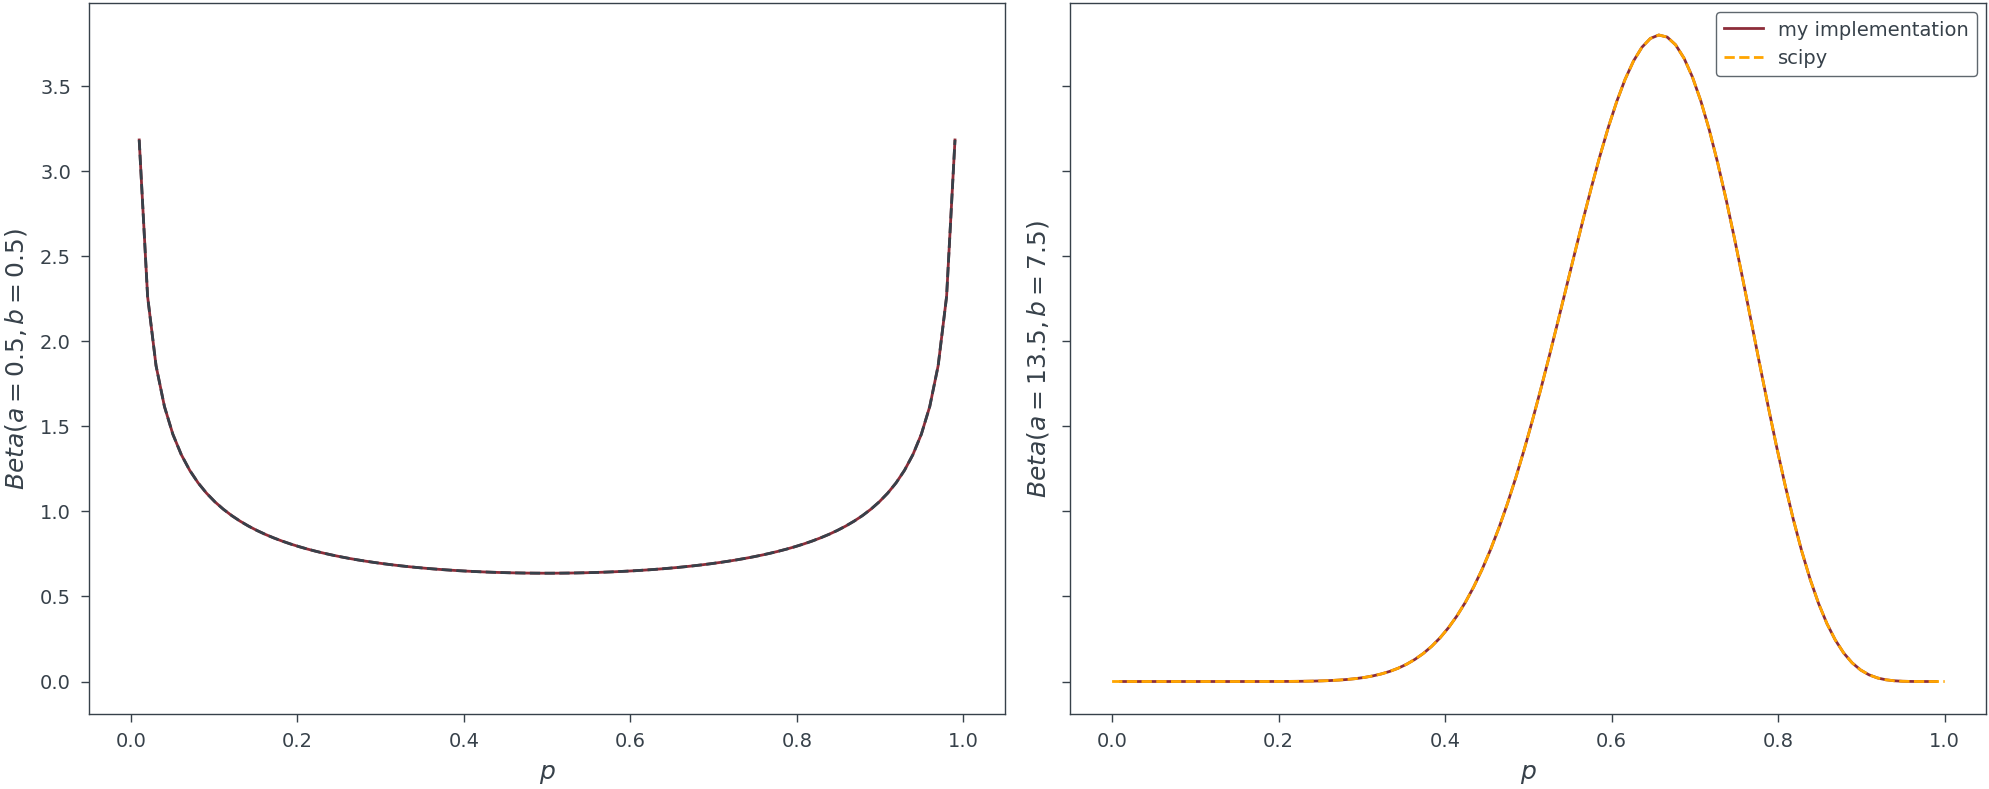

In [114]:
# Some unit tests to make sure your implementation is correct:
# instantiate your EF, and its conjugate prior:
likelihood = BinomialLogOdds(n=1)

prior = likelihood.conjugate_prior()

# Prior Natural Parameters: are alpha, nu.
a, b = 0.5, 0.5
prior_natural_parameters = [
    a,  # alpha
    a + b, # nu
]  # => Logistic-Beta(a, b)

# create some data:
key = jax.random.PRNGKey(0)
data = jax.random.bernoulli(key, 0.75, shape=(20, 1))

posterior = prior
posterior_natural_parameters = likelihood.posterior_parameters(
    prior_natural_parameters,
    data,
)

# A: Check your implementation of the conjugate prior is correctly normalized:
import scipy.integrate

np.testing.assert_allclose(
    scipy.integrate.quad(
        lambda logodds: np.exp(prior.logpdf(
            [logodds], prior_natural_parameters)),
        -30,
        30,
    )[0],
    1.0,
    rtol=1e-5,
    err_msg="The conjugate prior is not correctly normalized.",
)


# B: check your log pdf against the scipy implementation:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
fig.set_size_inches(10, 4)
plt_ps = np.linspace(0.0, 1.0, 100)

# first for the prior:
axs[0].plot(
    plt_ps,
    jnp.exp(
        sigmoid_logpdf_transform(
            lambda logodds: prior.logpdf(
                logodds[..., None], prior_natural_parameters)
        )(plt_ps[..., None])
    ), 
    label='my implementation'
)

axs[0].plot(plt_ps, jax.scipy.stats.beta.pdf(plt_ps, a, b),'--', label='scipy')
axs[0].set_xlabel(r"$p$")
axs[0].set_ylabel(f"$Beta(a={a}, b={b})$")

# then for the posterior:
axs[1].plot(
    plt_ps,
    jnp.exp(
        sigmoid_logpdf_transform(
            lambda logodds: posterior.logpdf(
                logodds[..., None], posterior_natural_parameters)
        )(plt_ps[..., None])
    ),
    label='my implementation'
)

axs[1].plot(plt_ps, jax.scipy.stats.beta.pdf(plt_ps, a + data.sum(), b + data.size - data.sum()),'--', label='scipy', color='orange')
axs[1].set_xlabel(r"$p$")
axs[1].set_ylabel(f"$Beta(a={a + data.sum()}, b={b + data.size - data.sum()})$")
axs[1].legend()


---
**Task B.** 

Add a `predictive_log_marginal_pdf(x, natural_parameters)` function to the `ExponentialFamily` above (a placeholder has already been included). It should compute

\begin{equation*}
    \log p(x \mid \alpha, \nu) = \log \int_\mathbb{W} p(x \mid w) p(w \mid \alpha, \nu) \mathrm{d}w.
\end{equation*}
This can be explicitly implemented in the abstract base class if the `conjugate_log_partition` is available. Revisit slide 10 of Lecture 5 for reference.

In fact, it is still possible to provide this functionality **approximately** even if `conjugate_log_partition` is *not* available, using the Laplace approximation. Add a `Laplace_predictive_log_marginal_pdf(self,x,natural_parameters, mode)` function to `ExponentialFamily`, which approximates the functionality of `predictive_log_marginal_pdf` when given a `mode` $w*=\operatorname{arg\,max}_w p(w\mid \alpha,\nu)$ (compare with the `laplace_precision` function already in `ConjugateFamily`). Revisit slide 7 of Lecture 6 for reference.

Test your implementation for the concrete example of the Binomial above (for the binomial, this marginal is known as the [Beta-Binomial](https://en.wikipedia.org/wiki/Beta-binomial_distribution) distribution).

In [115]:
def conjugate_mode(conjugate_natural_parameters):
    """Closed-form expression for the mode of the conjugate exponential family of the
    log-odds parametrized Binomial distribution."""
    return jnp.atleast_1d(
        jnp.log(
            conjugate_natural_parameters[0]
            / (conjugate_natural_parameters[1] - conjugate_natural_parameters[0])
        )
    )

([<matplotlib.axis.XTick at 0x7f9a90e087f0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

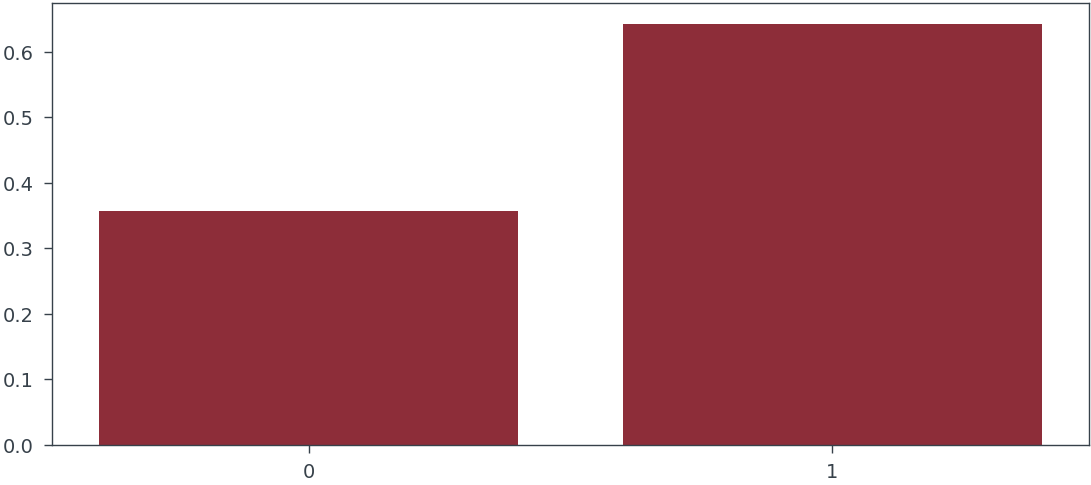

In [116]:
plt.bar(
    [0, 1],
    np.exp(
        likelihood.predictive_log_marginal_pdf(
            [[0], [1]],
            posterior_natural_parameters,
        )
    ),
)
plt.xticks([0, 1])

([<matplotlib.axis.XTick at 0x7f9a90e82da0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

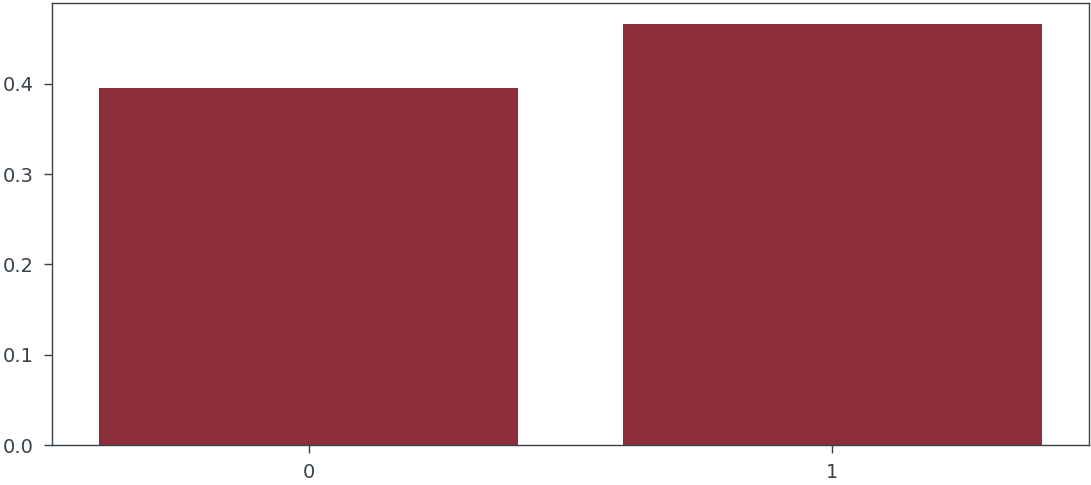

In [117]:
plt.bar(
    [0, 1],
    np.exp(
        likelihood.Laplace_predictive_log_marginal_pdf(
            [[0], [1]],
            jnp.reshape(posterior_natural_parameters, (2,1)), #posterior_natural_parameters,
            conjugate_mode(posterior_natural_parameters),
        )
    )
)
plt.xticks([0, 1])

([<matplotlib.axis.XTick at 0x7f9aa8678670>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

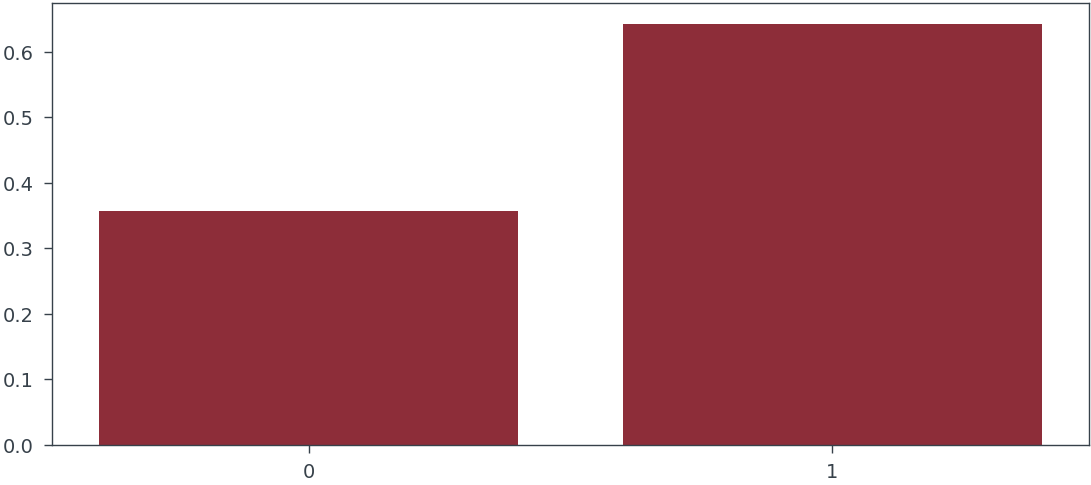

In [118]:
plt.bar(
    [0, 1],
    np.exp(
        likelihood.logpdf(
            [[0], [1]],
            conjugate_mode(posterior_natural_parameters),
        )
    )
)
plt.xticks([0, 1])

### How to submit your work:

Export your answer into a pdf (for example using jupyter's `Save and Export Notebook as` feature in the `File` menu). Make sure to include all outputs, in particular plots. Also include your answer to the theory question, either by adding it as LaTeX code directly in the notebook, or by adding it as an extra page (e.g. a scan) to the pdf. Submit the exercise on Ilias, in the associated folder. **Do not forget to add your name(s) and matrikel number(s) above!)**